In [59]:
import typing
import numpy as np
import pandas as pd

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

from fastai.basics import *

import matplotlib.pyplot as plt

In [60]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
chip_features = pd.read_csv("data/net1_chip_features.tsv", sep='\t')
gene_ids = pd.read_csv("data/net1_gene_ids.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')

In [61]:
X_idx = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]

In [62]:
synthetic_expression_data.values.shape

(805, 1643)

In [63]:
train, valid = map(torch.FloatTensor, (synthetic_expression_data.values[:600, :], synthetic_expression_data.values[600:, :]))

In [64]:
batch_size = 128
train_ds = TensorDataset(train[:, X_idx], train)
valid_ds = TensorDataset(valid[:, X_idx], valid)
data = DataBunch.create(train_ds, valid_ds, bs = batch_size)

In [65]:
X, Y = next(iter(data.train_dl))
X.shape, Y.shape

(torch.Size([128, 194]), torch.Size([128, 1643]))

In [99]:
class LinearMLP(nn.Module):
    """A pytorch module to build a (standard) Forward-Embedding Autoencoder"""

    def __init__(self, input_dim = 194, hidden_dim = 256, output_dim = 1643):
        """
        Parameters
        ----------
        input_dim : int
            The number of input features
        hidden_dim : int
            The number of features in the hidden layer
        output_dim : int
            The number of output features
        """
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
  
    def forward(self, X):
        X = self.fc1(X)
        X = self.fc2(X)
        return X
    
    def train(self, data_loader, optimizer, criterion):
        """
        Parameters
        ----------
        data_loader : torch.utils.data.DataLoader
        optimizer : torch.optim
        criterion : function
        """
        running_loss = 0
        for i, (X, Y) in enumerate(data_loader):
            optimizer.zero_grad()
            Y_hat = self.forward(X)
            loss = criterion(Y_hat, Y)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()
        print("Train loss: {0:.3f}".format(running_loss / (i + 1))) # MSE loss needs to be averaged over all batches
        return(running_loss / (i + 1))

    def test(self, data_loader, criterion):
        """
        Parameters
        ----------
        data_loader : torch.utils.data.DataLoader
        criterion : function
        """
        running_loss = 0
        for i, (X, Y) in enumerate(data_loader):
            Y_hat = self.forward(X)
            loss = criterion(Y_hat, Y) 
            running_loss += loss.item()
        print("Test loss: {0:.3f}".format(running_loss / (i + 1))) # MSE loss needs to be averaged over all batches
        return(running_loss / (i + 1))

In [106]:
lmlp_model = LinearMLP(input_dim, hidden_dim, output_dim)

In [118]:
loss_func = nn.MSELoss()
input_dim = sum(X_idx)
hidden_dim = 256
output_dim = synthetic_expression_data.shape[1]
lr=2e-3

In [123]:
def update_batch(model, X, Y, lr, train = True):
    """
    """
    Y_hat = model(X)
    train_loss = loss_func(Y_hat, Y)
    if train:
        opt = optim.Adam(model.parameters(), lr)
        train_loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

In [124]:
losses = [update_batch(lmlp_model, X, Y, lr) for X, Y in data.train_dl]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-124-f3fd3e91dd8f>", line 1, in <module>
    losses = [update_batch(X, Y, lr) for X, Y in data.train_dl]
  File "<ipython-input-124-f3fd3e91dd8f>", line 1, in <listcomp>
    losses = [update_batch(X, Y, lr) for X, Y in data.train_dl]
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/basic_data.py", line 75, in __iter__
    for b in self.dl: yield self.proc_batch(b)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 193, in __iter__
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 442, in __init__
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/context.py", line 102, in Queue
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues

OSError: [Errno 24] Too many open files

In [111]:
epochs = 25
train_loss, test_loss = [], []
for e in range(epochs):
    print("Epoch {} of {}".format(e+1, epochs+1))
    train_loss.append( lmlp_model.train(data.train_dl, optimiser, criterion) )
    test_loss.append( lmlp_model.test(data.valid_dl, criterion) )

Epoch 1 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 2 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 3 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 4 of 26
Train loss: 0.466
Test loss: 0.474
Epoch 5 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 6 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 7 of 26
Train loss: 0.468
Test loss: 0.474
Epoch 8 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 9 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 10 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 11 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 12 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 13 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 14 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 15 of 26
Train loss: 0.466
Test loss: 0.474
Epoch 16 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 17 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 18 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 19 of 26
Train loss: 0.466
Test loss: 0.474
Epoch 20 of 26
Train loss: 0.467
Test loss: 0.474
Epoch 21 

In [ ]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], test_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [89]:
learn = Learner(data, FEA(input_dim, hidden_dim, output_dim), loss_func=loss_func, wd=0)

In [70]:
learn.fit(epochs = 25, lr = 2e-3)

epoch,train_loss,valid_loss,time
0,0.267866,0.111356,00:00
1,0.168833,0.075680,00:00
2,0.130790,0.056360,00:00
3,0.107556,0.051443,00:00
4,0.092405,0.046580,00:00
5,0.081830,0.045940,00:00
6,0.073866,0.044085,00:00
7,0.067662,0.044091,00:00
8,0.062740,0.042107,00:00
9,0.058625,0.041616,00:00


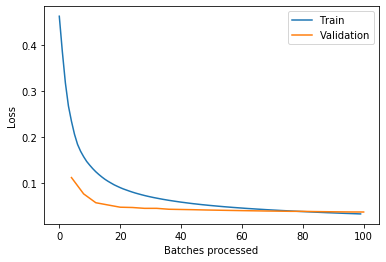

In [71]:
learn.recorder.plot_losses()

In [72]:
X, Y = next(iter(data.train_dl))
X.shape, Y.shape

(torch.Size([128, 194]), torch.Size([128, 1643]))

In [73]:
Y_hat = learn.model(X[5]).detach().numpy()
Y_obs = Y[5].detach().numpy()

(0, 1.5)

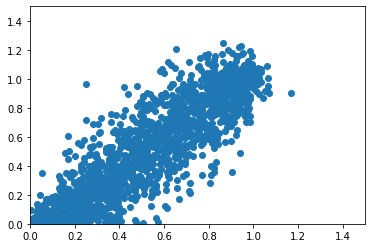

In [74]:
plt.scatter(Y_hat, Y_obs)
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)